# Recognition of Kannada Numbers 

Authors:

1. Alka Ashok
2. Haripriya Reddy


# 1. Introduction
Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script.


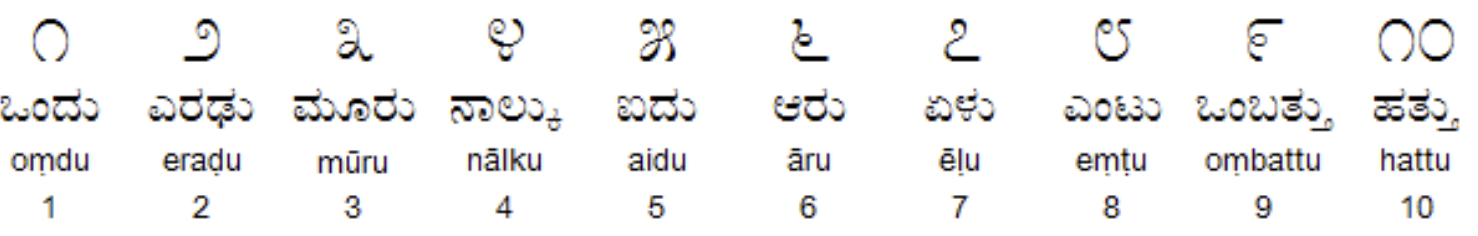

All details of the dataset curation has been captured in the paper titled: Prabhu, Vinay Uday. "Kannada-MNIST: A new handwritten digits dataset for the Kannada language." arXiv preprint arXiv:1908.01242 (2019)

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

#from keras.datasets import mnist

# 2. Data preparation
## 2.1 Loading the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
print("Data are Ready!!")

Data are Ready!!


In [3]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (60000, 785)
Testing data size is (5000, 785)


**Set data features and labels**

In [4]:
X = train.drop(['label'], 1).values
y = train['label'].values

## 2.2 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [5]:
X = X / 255.0

## 2.3 Reshape

In [6]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X = X.reshape(-1,28,28,1)

## 2.4 Label encoding

**One-Hot Encoding**

In [7]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (60000, 10)


Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.5 Split training and valdiation set

In [8]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((54000, 28, 28, 1), (6000, 28, 28, 1), (54000, 10), (6000, 10))

We choose to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

**Data Visualization**

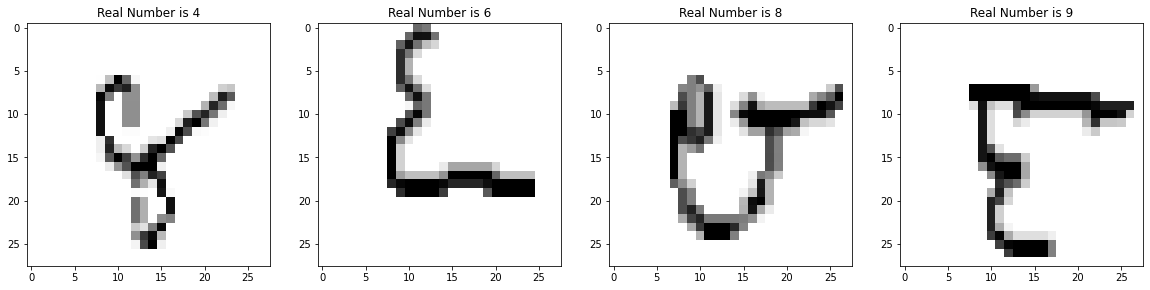

In [10]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

**Normalization**

In [11]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

# 3. CNN

* In Deep Learning, Convolutional Neural Network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery.
* It has applications in image and video recognition, recommender systems, image classification, medical image analysis, and natural language processing
* The name “Convolutional Neural Network” indicates that the network employs a mathematical operation called convolution. Convolution is a specialized kind of linear operation. Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers
* A convolutional neural network consists of one or several convolutional layers, followed by some fully connected layers of neurons like in classical multilayer feedforward neural networks.
* The hidden layers of a CNN typically consist of convolutional layers, pooling layers, fully connected layers and normalization layers.

**Convolution Operation**

You can think of left one as the “input” signal (or image), and the other (called the kernel) as a “filter” on the input image, producing an output image (so convolution takes two matrix as input and produces a third as output).

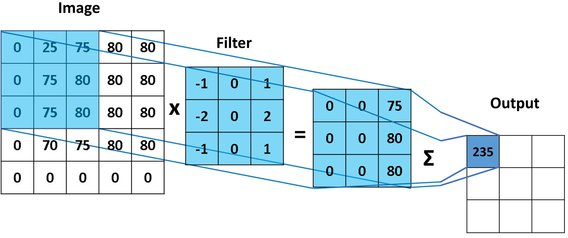

**Steps of convulation operation**
- Take the element wise production of the upper left corner sub-matrix and filter
- Then sum all row and column to obtain a single value
- Result is the upper corner cell's value of your new output matrix. (output(0,0))
- After that, slide the filter over "S" column on main image and do the same thing. You have your output(0,1) value.

**Stride** 
- Sliding amount is declared by stride (S) constant.
- According to problem stride content may vary change and this will directly effect on output dimensions.
- Calculation of output matrix dimension for  l 'th layer:

\begin{equation}
n^{l} = \frac{n^{l-1} - f}{s}+1 \\
\text{output} =  n^l x n^l
\end{equation}
Where;
- _l_  demonstrates the layer number.
- _nl_  is the horizontal/vertical dimension of output matrix.
- _nl−1_  is the horizontal/vertical dimension of input matrix.
- _f_  is the horizontal/vertical dimension of filter (kernel) matrix.
- _s_  is the stride constant. Using for determine how many columns will kernel shift to right side in order to calculate output matrixes next cell.


## 3.1 Define the model

Here we just have to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two second layers and 128 filters for two third layers and 256 for the last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

**Model Definition**

In [12]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

## 3.2 Data augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important : 
   - Without data augmentation we obtained an accuracy of 98.114%
   - With data augmentation we achieved 99.67% of accuracy

In [14]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

For the data augmentation the following parameters were set :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   

## 3.3 Model training

In [36]:
# This make accuarcy 0.998
#model.fit(X, y, batch_size=batch_size, validation_split=0.2, epochs=10)

### Drive training phase
**EarlyStoping**: Stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving.

In [15]:
epochs = 3
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(monitor="val_acc", patience=10, verbose=1,mode="max", restore_best_weights=True)

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [16]:
# Fit the model
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

<ipython-input-16-2676189ccf2f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/3
421/421 [==============================] - 125s 296ms/step - loss: 0.0966 - accuracy: 0.9701 - val_loss: 8.4295 - val_accuracy: 0.1063 - lr: 0.0010
Epoch 2/3
421/421 [==============================] - 111s 265ms/step - loss: 0.0376 - accuracy: 0.9881 - val_loss: 0.0671 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 3/3
421/421 [==============================] - 109s 258ms/step - loss: 0.0325 - accuracy: 0.9899 - val_loss: 0.0400 - val_accuracy: 0.9881 - lr: 0.0010


# 4. Evaluate the model
## 4.1 Training and validation curves

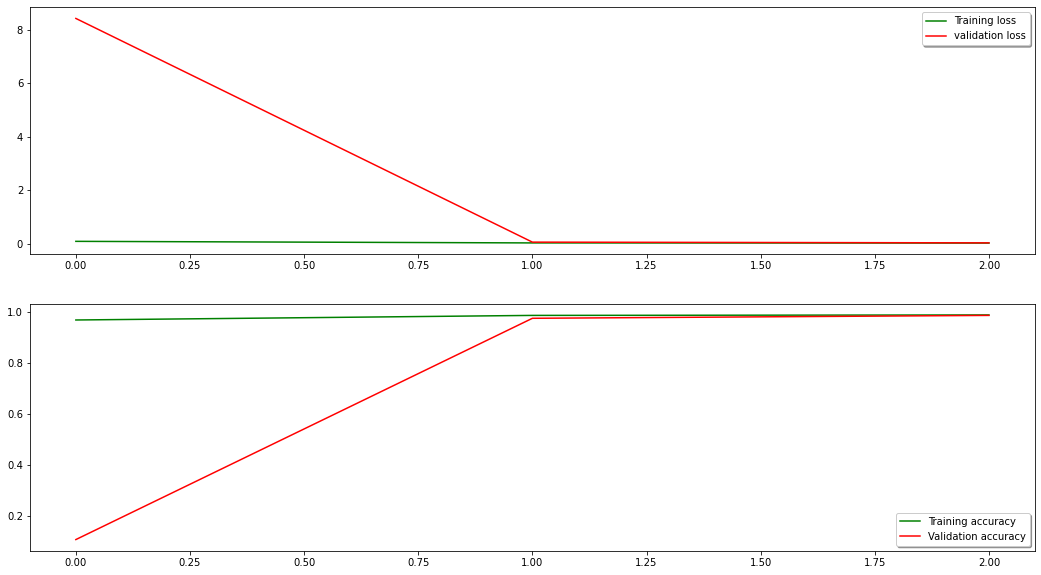

In [17]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='g', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='g', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

We plotted the confusion matrix of the validation results.

188/188 [==============================] - 4s 20ms/step


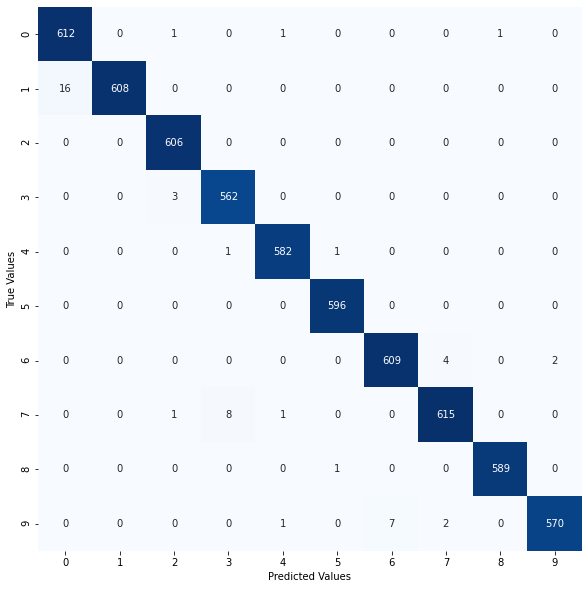

In [18]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

# 5. Prediction and submition

## 5.1 Prediction validation results

188/188 [==============================] - 4s 19ms/step


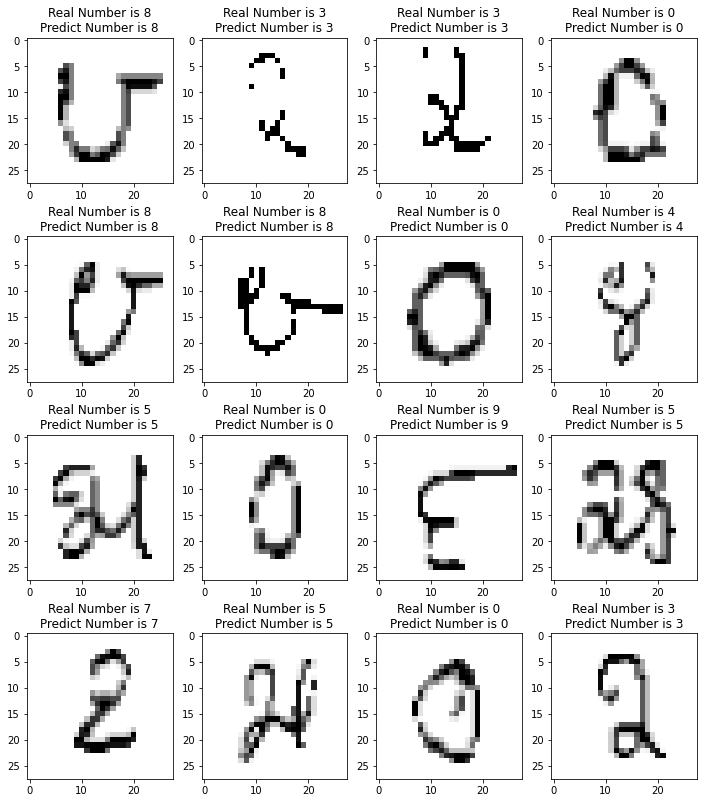

In [19]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):a
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## SVC

In [20]:
from sklearn.svm import SVC

#SVC classifier
svc = SVC()

# Fit the classifier to the training data
svc.fit(X_train.reshape(len(X_train), -1), y_train.argmax(axis=1))

# Evaluate the classifier on the test data
test_score = svc.score(X_test.reshape(len(X_test), -1), y_test.argmax(axis=1))

print("Test accuracy:", test_score)


Test accuracy: 0.9861666666666666


188/188 [==============================] - 4s 20ms/step


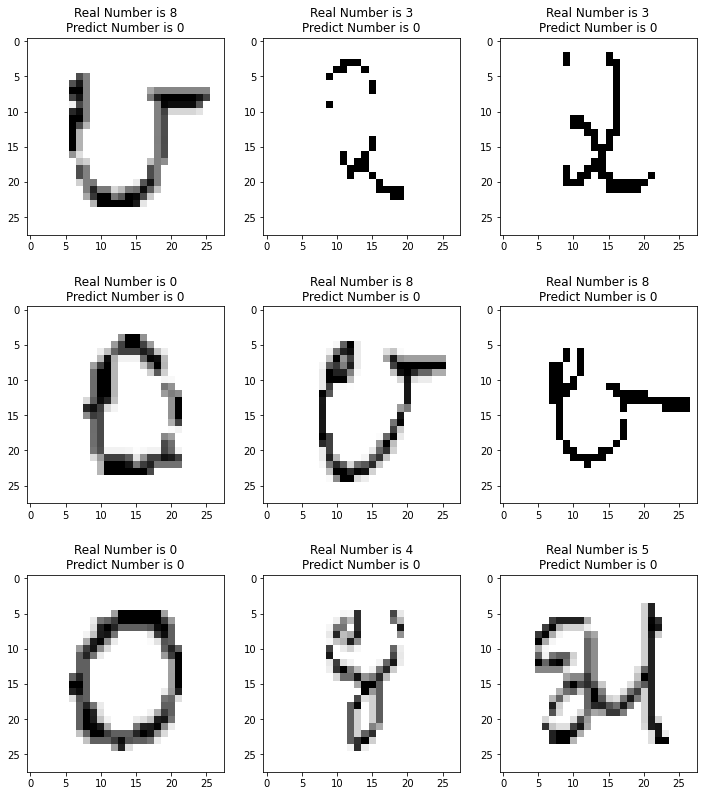

In [21]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = svc.predict(X_test.rshape(len(X_test), -1))

# Plot sample images with true and predicted labels
fig, axis = plt.subplots(3, 3, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

In [79]:
print("SVC accuracy: {:.2%}".format(test_score))

score = model.evaluate_generator(test_gen, steps=valid_steps)
print("CNN Accuracy: {:.2%}".format(score[1]))


SVC accuracy: 98.62%


<ipython-input-79-06110c5cbe0b>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_gen, steps=valid_steps)


CNN Accuracy: 98.85%


The :.2% format specifier formats the value as a percentage with two decimal places.

### Conclusion

CNN model out performs the SVC model by 0.23%

In [44]:
import pandas as pd
from sklearn.metrics import classification_report

# For CNN
y_true_cnn = y_test.argmax(axis=1)
y_pred_cnn = model.predict(X_test).argmax(axis=1)

# For SVC
y_true_svc = y_test.argmax(axis=1)
y_pred_svc = svc.predict(X_test.reshape(len(X_test), -1))


cnn_report = classification_report(y_true_cnn, y_pred_cnn, output_dict=True)


cnn_df = pd.DataFrame(cnn_report).transpose()

svc_report = classification_report(y_true_svc, y_pred_svc, output_dict=True)


svc_df = pd.DataFrame(svc_report).transpose()


comparison_df = cnn_df.compare(svc_df, keep_shape=True, keep_equal=True).rename(columns={'self': 'CNN', 'other': 'SVC'}, level=-1)

print("Classification Report Comparison:")
print(comparison_df)


188/188 [==============================] - 4s 21ms/step
Classification Report Comparison:
             precision              recall            f1-score            \
                   CNN       SVC       CNN       SVC       CNN       SVC   
0             0.995122  0.990338  0.974522  0.979299  0.984714  0.984788   
1             0.974359  0.979032  1.000000  0.998355  0.987013  0.988599   
2             1.000000  1.000000  0.991817  0.993453  0.995892  0.996716   
3             0.994690  0.977273  0.984238  0.978984  0.989437  0.978128   
4             0.996575  0.988115  0.994872  0.994872  0.995723  0.991482   
5             1.000000  0.993344  0.996656  0.998328  0.998325  0.995830   
6             0.990244  0.963434  0.988636  0.983766  0.989439  0.973494   
7             0.984000  0.977049  0.990338  0.959742  0.987159  0.968318   
8             0.998305  0.998299  0.998305  0.994915  0.998305  0.996604   
9             0.982759  0.996448  0.996503  0.980769  0.989583  0.988546  